# T-score

This notebook contains a pipeline for comparing the vocabulary of two sets of Tactus emails with eachother by the t-score. The goal is to find tokens which appear more frequently in one set than in the other, and vice versa. This notebook uses much of the preprocessing of the notebook liwc.py in this directory. 

The first code block specifies the required libraries. This includes some general Python libraries and some specific libraries developed in our research project. These project-specific libraries can be found in the folder orangehackathon/libs

In [1]:
import csv
import re
import sys
import time
from IPython.display import clear_output

sys.path.append("../libs/")
import tactusloaderLIB
import OWEmailSorterLIB
import markduplicatesLIB
import removemarkedtextLIB
import LIWCLIB

The next code block specifies the location of the therapy files

In [2]:
DIRECTORY = "/home/erikt/projects/e-mental-health/usb/releases/20200320"

The therapy files are read with the Orange3 pipeline. The Orange3 pipeline contains these parts:

1. tactusloader: determine file name and read its contents
2. sortMails: sort the mails from the file chronologically
3. markduplicates: mark the parts of the mail text included from an earlier mail
4. removemarkedtext: remove the marked text from the mail
5. LIWC: analyse the text with LIWC

The file loading takes several minutes. The program counts from 1 to the number of files to indicate its progress.

In [3]:
MAXCLIENT = 1987

def readTactusData(maxClient):
    allLiwcResults = {}
    allMails = {}
    emptyFiles = []
    problemFiles = []
    for patientId in range(1,maxClient+1):
        clear_output(wait=True)
        print("processing:",patientId)
        fileName = tactusloaderLIB.makeFileName(str(patientId))
        fileNameId = re.sub("-an.xml$","",fileName)
        try:
            mails = tactusloaderLIB.processFile(DIRECTORY,fileName+".gz")
            if len(mails[0]) > 0:
                sortedMails = OWEmailSorterLIB.filterEmails(mails[0],filter_asc=True)
                markedMails = markduplicatesLIB.processCorpus(sortedMails)
                strippedMails = removemarkedtextLIB.processCorpus(markedMails)
                liwcResults = LIWCLIB.processCorpus(strippedMails)
                allLiwcResults[fileNameId] = liwcResults
                allMails[fileNameId] = strippedMails
            else: emptyFiles.append(fileName)
        except:
            problemFiles.append(fileName)
            continue
    if len(emptyFiles) > 0:
        print("Found empty or nonexistant files:",emptyFiles)
    if len(problemFiles) > 0:
        print("There were problems processing these files:",problemFiles)
    return(allLiwcResults,allMails)

allLiwcResults,allMails = readTactusData(MAXCLIENT)

processing: 1987
Found empty or nonexistant files: ['AdB0538-an.xml', 'AdB1263-an.xml', 'AdB1469-an.xml', 'AdB1630-an.xml', 'AdB1826-an.xml']


In [4]:
len(allMails)

1982

We will comparethe texts in emails from clients that finished the treatment versus clients that dropped out. Thus we need the metadata which specifies the results of the therapy for each client.

In [5]:
import gzip

DIRDROPOUT = "/home/erikt/projects/e-mental-health/usb/releases/20200305/"
FILEDROPOUT = "selected.csv.gz"
DELIMITER = ","
FIELDNAMEDROPOUT = "dropout"
FIELDNAMETEXT = "text"
FIELDNAMEFILE = "file"
FIELDNAMEFROM = "from"
CLIENT = "CLIENT"
COUNSELOR = "COUNSELOR"
NBROFCLIENTS = 791
CODEDROPOUT = "1"
CODEFINISHER = "2"

dropout = {}
inFile = gzip.open(DIRDROPOUT+FILEDROPOUT,"rt",encoding="utf-8")
csvreader = csv.DictReader(inFile,delimiter=DELIMITER)
for row in csvreader: dropout[row[FIELDNAMEFILE]] = row[FIELDNAMEDROPOUT]
inFile.close()

len([x for x in dropout if dropout[x] != "?"]) == NBROFCLIENTS

True

We will compare collections of texts with the t-score. First we will compute the t-scores of various text collections with a function `makeTscoreData`. After this we can compare these t-scores with the function `compareTscoreData`. We rely on the t-score script `/home/erikt/projects/newsgac/fasttext-runs/tscore.py` for making the comparisons. 

There are two ways for computing the t-scores: count every separate word used by a client or count each word used by a client only once. The texts can be prepared for the second type of counts with the function `removeDuplicateTokensTextArray` which removes all duplicate words from the texts (case-sensitive).

In [6]:
NBROFTOKENS = "totalFreq"
NBROFTYPES = "nbrOfWords"
WORDFREQS = "wordFreqs"
NBROFGROUPS = "nbrOfGroups"

def normalizeMaxCount(tscoreData,fraction):
    tscoreData[MAXCOUNT] = round(tscoreData[MAXCOUNT]*fraction,1)
    for word in tscoreData["wordFreqs"]:
        tscoreData["wordFreqs"][word] = round(tscoreData["wordFreqs"][word]*fraction,1)
    return(tscoreData)

def removeEmptyMails(textArrayIn):    
    return([text for text in textArrayIn if text != ""])

def removeDuplicateTokensText(text):
    seen = {}
    for word in text.split():
        if not word in seen: seen[word] = True
    return(" ".join(list(seen.keys())))

def removeDuplicateTokensTextArray(textArrayIn):
    textArrayOut = []
    for text in textArrayIn:
        textArrayOut.append(removeDuplicateTokens(text))
    return(textArrayOut)

def makeTscoreData(textArray):
    data = { NBROFTOKENS:0, NBROFTYPES:0, NBROFGROUPS:len(textArray), WORDFREQS:{} }
    for text in textArray:
        for token in text.split():
            data[NBROFTOKENS] += 1
            if token in data[WORDFREQS]: 
                data[WORDFREQS][token] += 1
            else:
                data[WORDFREQS][token] = 1
                data[NBROFTYPES] += 1
    return(data)

def makeTscoreDataBigrams(textArray):
    data = { NBROFTOKENS:0, NBROFTYPES:0, NBROFGROUPS:len(textArray), WORDFREQS:{} }
    for text in textArray:
        tokens = text.split()
        for i in range(1,len(tokens)):
            bigram = tokens[i-1]+" "+tokens[i]
            data[NBROFTOKENS] += 1
            if bigram in data[WORDFREQS]: 
                data[WORDFREQS][bigram] += 1
            else:
                data[WORDFREQS][bigram] = 1
                data[NBROFTYPES] += 1
    return(data)

In [7]:
sys.path.append("/home/erikt/projects/newsgac/fasttext-runs")
import tscore
import operator
from termcolor import colored
# alternative: from IPython.display import Markdown; display(Markdown("htmlcode"))

HIGHLIGHTCOLOR = "blue"
ADDEDSPACES = 9
MAXSTRING = 20

def fillAddedSpaces(tokenLen):
    addedSpaces = ""
    i = 0
    while i < ADDEDSPACES and tokenLen+i-ADDEDSPACES < MAXSTRING:
        addedSpaces += " "
        i += 1
    return(addedSpaces)

def compareTscoreData(tscoreData1,tscoreData1reference,tscoreData2,tscoreData2reference,nbrOfShow,coloredWords=[]):
    outFile = open("out.csv","w")
    csvwriter = csv.DictWriter(outFile,["position","token","tscore","freqDropouts","freqFinishers"])
    csvwriter.writeheader()
    tscores1 = tscore.computeTscore(tscoreData1,tscoreData1reference)
    tscores2 = tscore.computeTscore(tscoreData2,tscoreData2reference)
    tscores1sorted = sorted(tscores1.items(), key=operator.itemgetter(1),reverse=True)
    tscores2sorted = sorted(tscores2.items(), key=operator.itemgetter(1),reverse=True)
    combined = [ tscores1sorted[i]+tscores2sorted[i] for i in range(min(len(tscores1sorted),len(tscores2sorted))) ]
    position = 0
    for tuple in combined:
        position += 1
        (token1,token1Tscore,token2,token2Tscore) = tuple
        if token1 in tscoreData1[WORDFREQS]: frequency11 = tscoreData1[WORDFREQS][token1]
        else: frequency11 = 0
        if token1 in tscoreData1reference[WORDFREQS]: frequency1r = tscoreData1reference[WORDFREQS][token1]
        else: frequency1r = 0
        if token2 in tscoreData2[WORDFREQS]: frequency22 = tscoreData2[WORDFREQS][token2]
        else: frequency22 = 0
        if token2 in tscoreData2reference[WORDFREQS]: frequency2r = tscoreData2reference[WORDFREQS][token2]
        else: frequency2r = 0
        csvwriter.writerow({"position":position,"token":token1,"tscore":token1Tscore,\
                            "freqDropouts":frequency11,"freqFinishers":frequency1r})
        if position <= nbrOfShow:
            token1AddedSpaces = ""
            if token1 in coloredWords: 
                token1 = colored(token1,HIGHLIGHTCOLOR)
                token1AddedSpaces = fillAddedSpaces(len(token1))
            if token2 in coloredWords: token2 = colored(token2,HIGHLIGHTCOLOR)
            print("{0:6d}. {2:5.1f} {3:7d} {4:7d} {1:<20s}{5:s} {0:6d}. {7:5.1f} {8:7d} {9:7d} {6:<20s}".\
                  format(position,token1,round(token1Tscore,1),frequency11,frequency1r,token1AddedSpaces, \
                                  token2,round(token2Tscore,1),frequency22,frequency2r))
    outFile.close()

Now we choose the text collections that we want to compare. Here are the choices:

1. all mails of all clients
2. all mails of all counselors
3. the final mail written by a counselor to a client that dropped out
4. the final mail written to a counselor to a client that finished the therapy
5. the first four mails of a client that dropped out
6. the first four mails of a client that finished the therapy
7. the long mails among the first four mails of a client that dropped out
8. the long mails among the first four mails of a client that finished the therapy
9. all mails of all clients that dropped out
10. all mails of all clients that finished the therapy

In [8]:
clientWithMails = [ clientId for clientId in allMails.keys() if len(allMails[clientId]) > 0 ][0]
textFieldId = LIWCLIB.getFieldId(allMails[clientWithMails][0],FIELDNAMETEXT) 

def wordCount(text): return(len(text.split()))

def selectMailsFrom(mails,sender):
    return([ mail for mail in mails if mail[FIELDNAMEFROM] == sender ])

def selectAllMailTextFrom(mails,sender):
    return(" ".join([ mail.metas[textFieldId] for mail in selectMailsFrom(mails,sender) ]))

def selectLastNMailTextsFrom(mails,sender,n):
    return(" ".join([ mail.metas[textFieldId] for mail in selectMailsFrom(mails,sender) ][-n:]))

def selectFirstNMailTextsFrom(mails,sender,n,cutoff=0):
    firstNtexts = [ mail.metas[textFieldId] for mail in selectMailsFrom(mails,sender) ][0:n]
    return(" ".join([ text for text in firstNtexts if wordCount(text) >= cutoff ]))

allMailsClients = [ selectAllMailTextFrom(allMails[thisId],CLIENT) for thisId in allMails ]
allMailsCounselors = [ selectAllMailTextFrom(allMails[thisId],COUNSELOR) for thisId in allMails ]

NBROFSELECTED = 1
lastCounselorMails = { thisId:selectLastNMailTextsFrom(allMails[thisId],COUNSELOR,NBROFSELECTED) for thisId in allMails }
lastCounselorMailsDropout = [ lastCounselorMails[clientId] for clientId in dropout if dropout[clientId] == CODEDROPOUT ]
lastCounselorMailsFinisher = [ lastCounselorMails[clientId] for clientId in dropout if dropout[clientId] == CODEFINISHER ]

NBROFSELECTED = 4
firstFourClientMails = { thisId:selectFirstNMailTextsFrom(allMails[thisId],CLIENT,NBROFSELECTED) for thisId in allMails }
firstFourClientMailsDropout = [ firstFourClientMails[clientId] for clientId in dropout if dropout[clientId] == CODEDROPOUT ]
firstFourClientMailsFinisher = [ firstFourClientMails[clientId] for clientId in dropout if dropout[clientId] == CODEFINISHER ]

CUTOFF = 1000
NBROFSELECTED = 4
firstFourClientMailsCutoff = { thisId:selectFirstNMailTextsFrom(allMails[thisId],CLIENT,NBROFSELECTED,cutoff=CUTOFF) for thisId in allMails }
firstFourClientMailsCutoffDropout = [ firstFourClientMailsCutoff[clientId] for clientId in dropout if dropout[clientId] == CODEDROPOUT ]
firstFourClientMailsCutoffFinisher = [ firstFourClientMailsCutoff[clientId] for clientId in dropout if dropout[clientId] == CODEFINISHER ]

allMailsClientsDropout = [ selectAllMailTextFrom(allMails[clientId],CLIENT) for clientId in allMails if dropout[clientId] == CODEDROPOUT ]
allMailsClientsFinisher = [ selectAllMailTextFrom(allMails[clientId],CLIENT) for clientId in allMails if dropout[clientId] == CODEFINISHER ]

len(removeEmptyMails(allMailsClients)),len(removeEmptyMails(allMailsCounselors)),\
len(removeEmptyMails(lastCounselorMailsDropout)),len(removeEmptyMails(lastCounselorMailsFinisher)),\
len(removeEmptyMails(firstFourClientMailsDropout)),len(removeEmptyMails(firstFourClientMailsFinisher)),\
len(removeEmptyMails(firstFourClientMailsCutoffDropout)),len(removeEmptyMails(firstFourClientMailsCutoffFinisher)), \
len(removeEmptyMails(allMailsClientsDropout)),len(removeEmptyMails(allMailsClientsFinisher))

(1115, 1982, 437, 354, 433, 354, 78, 114, 433, 354)

There is a difference in the number of dropout sessions with counselor mails (437) and the number of dropout sessions with client mails (433). The reason for this is that there are four clients which contributed only a single empty mail to the session.  

In [9]:
for thisId in allMails:
    mailText = selectAllMailTextFrom(allMails[thisId],CLIENT)
    if (dropout[thisId] == "1" or dropout[thisId] == "2") and len(mailText) == 0: print(thisId,dropout[thisId])

AdB0286 1
AdB0399 1
AdB0417 1
AdB0610 1


Since we have selected different groups of text, we can use the t-score for comparing the word usage in our group with another. Note that the comparison results will be better for larger word groups. In general it does not makes sense to compare two small groups of texts because neither of the two will provide a good model of the language to compare the other with. In those cases it is better to compare a small text with a large text.

## Comparing all mail texts: dropouts vs finishers

The two groups of all dropout mails and all finisher mails are large enough to compare with each other. However the results may not be very useful for two reasons. First, on average the finishers took part in the therapy for a longer time than the dropouts. So they participated more frequently in later assignments and the language used in these assignments will have an effect on the measurements. A second reasond reason for the results being less interesting is that we would like to detect likely dropouts as early as possible in the therapy, so we do not have the time to collect their responses during several weeks.  

In [10]:
NBROFSHOW = 40

print("counts:","allMailsClientsDropout:",sum([wordCount(text) for text in allMailsClientsDropout]), \
                "tokens;",len(removeEmptyMails(allMailsClientsDropout)),"mails;", \
                "allMailsClientsFinisher:",sum([wordCount(text) for text in allMailsClientsFinisher]), \
                "tokens;",len(removeEmptyMails(allMailsClientsFinisher)),"mails" )
tscoreData1 = makeTscoreData(removeEmptyMails(allMailsClientsDropout))
tscoreData2 = makeTscoreData(removeEmptyMails(allMailsClientsFinisher))
compareTscoreData(tscoreData1,tscoreData2,tscoreData2,tscoreData1,NBROFSHOW,\
                  coloredWords=["relatie","kinderen","huisarts","partner","ex","ouders","vrienden","contacten","vriendin",\
                                "pols","vinger","actieplan","nameting","traject","opdracht"])

counts: allMailsClientsDropout: 917757 tokens; 433 mails; allMailsClientsFinisher: 2495998 tokens; 354 mails
     1.  26.2   14142   28707 NUM                       1.  13.1    1442     255 gedachten           
     2.  13.8   10837   24838 mijn                      2.  11.4   11574    3467 weer                
     3.  11.0    1732    3300 werk                      3.  11.4   53097   17836 het                 
     4.  10.7    1671    3196 jaar                      4.  11.3     252      14 pols       
     5.  10.6     657     972 --                        5.  11.2    4079    1058 mezelf              
     6.  10.5     993    1688 ..                        6.  11.2     453      49 helpende            
     7.  10.0     298     308 IK                        7.  11.1     262      16 vinger     
     8.   9.9    1725    3410 drink                     8.  10.9   13781    4245 nog                 
     9.   9.1     131      65 >                         9.  10.1     202      11 actieplan  


The fact that the finishers completed a larger part of the therapy is indeed reflected in their word usage, in particular by the therapy words *pols*, *vinger*, *actieplan*, *nameting*, *traject* and *opdracht*. The word *Dank* is also interesting here (displaying gratitude for a successful therapy?) as well as the two food-related diminuitives (*etentje* and *pilsje*: ability to relativate?). *gedachten*, *denken* and *herken* show the ability to reflect but may be invoked by later assignments. *trek* is an old-fashioned words correlated with the age of the client. The comma (*,*) was more used in this group (longer sentences?) while the periode (*.*) was more used by the dropouts (shorter sentences?).

Interestingly, dropouts use more numbers (*NUM*) in their mails and more frequently refer to themselves (*mijn* and *Mijn*). The word *IK* is less interesting: it is an unusual spelling of a common word. There are seven more of these (*HET*, *DAT*, *VAN*, *DE*, *MIJN*, *EN* and *IS*) but they could be caused by a few clients writing all caps. There are many references to people and relations: *relatie*, *kinderen*, *huisarts*, *partner*, *ex*, *ouders*, *vrienden*, *contacten* and *vriendin*). *huisarts* could be used because of medical problems or extreme drinking behavior. While the finishers did not use negative words frequently, the dropouts did: *nadelen*, *problemen* and *klachten*. Two other interesting related words are *werk* and *hobby*, and there are also the three behavior-related words *drink*, *gebruik* and *stoppen*.

The next function `collocations()` can be used to lookup tokens in context in the mails. For example, we expected that the word *pols* was predominantly used in the context of the name of the Tactus treatment programme *Vinger aan de pols* rather than in the literal meaning (*wrist*). Searching forthe contexts of the token with the `collocations()` function confirmed this expectation.

In [11]:
UNDEFINED = "UNDEF"
NBROFTOKENSAFTER = 0
NBROFTOKENSBEFORE = 3
NBROFCOLLOCATIONS = 20

def makeCollocation(tokens,i,nbrOfTokensBefore,nbrOfTokensAfter):
    collocationList = [tokens[i]]
    for j in range(i-1,i-nbrOfTokensBefore-1,-1):
        if j >= 0: collocationList = [tokens[j]]+collocationList
        else: collocationList = [UNDEFINED]+collocationList
    for j in range(i+1,i+nbrOfTokensAfter+1):
        if j < len(tokens): collocationList.append(tokens[j])
        else: collocationList.append(UNDEFINED)
    return(" ".join(collocationList))
            
def addToCollocations(collocations,tokens,i,nbrOfTokensBefore,nbrOfTokensAfter):
    collocation = makeCollocation(tokens,i,nbrOfTokensBefore,nbrOfTokensAfter)
    if collocation in collocations: collocations[collocation] += 1
    else: collocations[collocation] = 1
        
def collocations(texts,token,nbrOfTokensBefore=NBROFTOKENSBEFORE,nbrOfTokensAfter=NBROFTOKENSAFTER,nbrOfCollocations=NBROFCOLLOCATIONS):
    collocations = {}
    total = 0
    for text in texts:
        tokens = text.split()
        for i in range(0,len(tokens)):
            if tokens[i] == token:
                total += 1
                addToCollocations(collocations,tokens,i,nbrOfTokensBefore,nbrOfTokensAfter)
    print("total:",total)
    for key,value in sorted(collocations.items(), key=lambda item: item[1],reverse=True)[0:nbrOfCollocations]:
        print(value,key)
        
collocations(allMailsClientsFinisher,"mijn",nbrOfCollocations=7)

total: 24838
112 . Ik heb mijn
67 is slecht voor mijn
59 de hoogte van mijn
47 het overlijden van mijn
34 te maken met mijn
30 . Ik zal mijn
30 de relatie met mijn


## Comparing the final counselor mails: dropouts vs finishers

We would like to know if it is possible to predict the result of the therapy (dropout vs finisher) based on the text of the final mail sent by the counselor. By themselves these mails do contain a lot of text so we compare them with all the mails of the counselors.

In [12]:
print("counts:","lastCounselorMailsDropout:",sum([wordCount(text) for text in lastCounselorMailsDropout]),\
                "tokens;",len(removeEmptyMails(lastCounselorMailsDropout)),"mails;", \
                "lastCounselorMailsFinisher:",sum([wordCount(text) for text in lastCounselorMailsFinisher]),\
                "tokens;",len(removeEmptyMails(lastCounselorMailsFinisher)),"mails" )
tscoreData1 = makeTscoreData(removeEmptyMails(lastCounselorMailsDropout))
tscoreData2 = makeTscoreData(removeEmptyMails(lastCounselorMailsFinisher))
tscoreData3 = makeTscoreData(removeEmptyMails(allMailsCounselors))
compareTscoreData(tscoreData1,tscoreData3,tscoreData2,tscoreData3,NBROFSHOW,
                  coloredWords=["invullen","vragenlijst","stuur","vullen","verzoek","actief","niet"])

counts: lastCounselorMailsDropout: 48929 tokens; 437 mails; lastCounselorMailsFinisher: 49138 tokens; 354 mails
     1.  30.6    1061   18305 dossier                   1.  18.6    1659  251950 het                 
     2.  20.9     788   56612 PER                       2.  15.3     352   18305 dossier             
     3.  20.4     722   49154 nog                       3.  13.3     221    6484 wens                
     4.  19.3     661   46846 kun                       4.  13.2     496   56612 PER                 
     5.  18.5    1247  167372 in                        5.  12.8     402   40689 !                   
     6.  18.4     360    3073 opnieuw                   6.  12.7     326   26874 Beste               
     7.  18.2     387    8153 berichten                 7.  12.0     622   90435 Ik                  
     8.  17.7     338    3362 MAIL                      8.  11.9     180    5655 ORG                 
     9.  17.7     322    1085 archief                   9.  11.1     127

The top finisher words provide the most clues for group identification. We observe calls to action (*invullen*, *vragenlijst*, *stuur*, *vullen* and *verzoek*) and expressions of completion (*afgerond* and *bedankt*). Among the top dropout words we find a reference to the clients status: *actief* (in combination with *niet*). *stuur* also appears here, in the instruction to the client on how to return to the programme.

In [13]:
collocations(lastCounselorMailsFinisher,"mijn",nbrOfTokensBefore=2,nbrOfTokensAfter=2,nbrOfCollocations=5)

total: 76
17 het e-mailbericht mijn naam en
2 van daar mijn wat onpersoonlijke
2 is inderdaad mijn laatste bericht
1 bereiken via mijn persoonlijke emailadres
1 Lees hiervoor mijn vorige bericht


## Comparing the first four client mails: dropouts vs finishers

In [14]:
print("counts:","firstFourClientMailsDropout:",sum([wordCount(text) for text in firstFourClientMailsDropout]),\
                "tokens;",len(removeEmptyMails(firstFourClientMailsDropout)),"mails;", \
                "firstFourClientMailsFinisher:",sum([wordCount(text) for text in firstFourClientMailsFinisher]),\
                "tokens;",len(removeEmptyMails(firstFourClientMailsFinisher)),"mails" )
tscoreData1 = makeTscoreData(removeEmptyMails(firstFourClientMailsDropout))
tscoreData2 = makeTscoreData(removeEmptyMails(firstFourClientMailsFinisher))
tscoreData3 = makeTscoreData(removeEmptyMails(allMailsClients))
compareTscoreData(tscoreData1,tscoreData3,tscoreData2,tscoreData3,NBROFSHOW,
                  coloredWords=["jaren","(","vaak","voordelen","top","werd","vader","In",\
                                "regelmatig","contact","Top","altijd","'s","naam",":",\
                                "ben","gebruik","hoogte","relatie","eet","partner","Vraag","heb","interesses",\
                                "ongeveer","ouders","vrijetijdsbesteding","beantwoorden","problemen","soms"])

counts: firstFourClientMailsDropout: 426946 tokens; 433 mails; firstFourClientMailsFinisher: 550226 tokens; 354 mails
     1.  33.4    8619   43970 NUM                       1.  28.7    9962   43970 NUM                 
     2.  17.2    1238    5018 jaar                      2.  16.7    1459    5018 jaar                
     3.  13.9    2843   16835 )                         3.  16.5    3722   16835 )                   
     4.  13.3    5558   36764 mijn                      4.  12.7    6937   36764 mijn                
     5.  13.1    1077    5144 werk                      5.  12.7    1227    4811 Mijn                
     6.  12.6    1077    5286 drink                     6.  10.1    1176    5144 werk                
     7.  12.2     529    1955 --                        7.   9.6     467    1593 dronk               
     8.  11.5     959    4811 Mijn                      8.   9.5     538    1955 --                  
     9.  10.0     204     477 hobby                     9.   9.3  

Most of the words (25 of 40) in the two top usage lists are the same, showing that the language usage in the early mails is different from that in the other mails. In particular this is true for some of the relation words that we found in the comparison between all dropout and finisher mails (*kinderen* and *vrienden*). Interestingly, the dropout list contains several first person singular verbs (*ben*, *gebruik*, *eet* and *heb*) not present in the finisher list with the exception of *drink*. The dropout list still contains more relative words (*relatie*, *partner* and *ouders*) than the finisher list.

A direct comparison between the two text collections reveals similar patterns: first person singular verb words (*heb*, *ben*, *drink* and *gebruik*) and relation words (*vriendin* and *zoontje*) among the top dropout words. A new topic is prominent among the finsher words: illnesses and physical problems (*kanker*, *pijn*, *chemo*, *arthritis*).

In [15]:
compareTscoreData(tscoreData1,tscoreData2,tscoreData2,tscoreData1,NBROFSHOW)

     1.   7.2    8619    9962 NUM                       1.   5.7      77      15 ‘                   
     2.   6.8     438     340 ..                        2.   5.4    2446    1604 die                 
     3.   6.4    5370    6121 heb                       3.   4.8     256     120 glas                
     4.   6.0    3298    3668 ben                       4.   4.6      41       6 therapeut           
     5.   5.5    2455    2708 PER                       5.   4.6     225     104 voelde              
     6.   5.4     101      50 u                         6.   4.5    2324    1563 was                 
     7.   5.3    1077    1103 drink                     7.   4.5     901     553 hij                 
     8.   5.1     706     688 ...                       8.   4.4      51      11 kanker              
     9.   4.8     388     349 gebruik                   9.   4.3      88      29 forum               
    10.   4.5      48      17 HET                      10.   4.2   10583    7726 h

## Comparing the longest among the first four client mails: dropouts vs finishers

In [16]:
print("counts:","firstFourClientMailsCutoffDropout:",sum([wordCount(text) for text in firstFourClientMailsCutoffDropout]),\
                "tokens;",len(removeEmptyMails(firstFourClientMailsCutoffDropout)),"mails;", \
                "firstFourClientMailsCutoffFinisher:",sum([wordCount(text) for text in firstFourClientMailsCutoffFinisher]),\
                "tokens;",len(removeEmptyMails(firstFourClientMailsCutoffFinisher)),"mails" )
tscoreData1 = makeTscoreData(removeEmptyMails(firstFourClientMailsCutoffDropout))
tscoreData2 = makeTscoreData(removeEmptyMails(firstFourClientMailsCutoffFinisher))
tscoreData3 = makeTscoreData(removeEmptyMails(allMailsClients))
compareTscoreData(tscoreData1,tscoreData3,tscoreData2,tscoreData3,NBROFSHOW,coloredWords=[\
                 "(","was",".","kon","contacten","kreeg","depressie",",","geleden","vader","broer","ad","familie","per","ORG","sinds",\
                 "kinderen","“","s","Vraag","drink","eet","”","soms","ben","dagelijks","…","hobby","maanden","ongeveer","baan","weinig"])

counts: firstFourClientMailsCutoffDropout: 125570 tokens; 78 mails; firstFourClientMailsCutoffFinisher: 227350 tokens; 114 mails
     1.  15.1    2351   43970 NUM                       1.  15.4     760    5018 jaar                
     2.  12.4     448    5018 jaar                      2.  14.2    3793   43970 NUM                 
     3.   9.8     917   16835 )                         3.  12.2    1609   16835 )                   
     4.   7.6     252    3560 toen                      4.   9.7     442    3560 toen                
     5.   7.4    1653   36764 mijn                      5.   8.9    1236   13884 (          
     6.   6.8     161    2027 kinderen                  6.   8.8     249    1636 werd                
     7.   6.6     591   11694 veel                      7.   8.7     518    4811 Mijn                
     8.   6.3      84     706 ’                         8.   8.3    1164   13272 was        
     9.   6.1     294    5144 werk                      9.   8.1     205 

When we examine only the longest (>= 1000 tokens) among the first four client mails, we see similar patterns: among the top dropout words several firts person singular verbs (*drink*, *eet* and *ben*) but person relation words (*kinderen* and *vader*) are now more present among the top finisher words (*contacten*, *vader*, *broer* and *familie*).

## Comparing LIWC data

We have compared word usage in the mail texts with the t-score. Next we want to compare the frequencies of LIWC categories in the mail texts. 

In [17]:
TOTALTOKENS = "Number of matches"
NBROFNBRS = "number count"
EMPTYLIWCDICT = { TOTALTOKENS:0, NBROFNBRS:0 }

def isLiwcFeature(featureName):
    return(re.search(r"^[0-9]",str(featureName)))

def combineLiwcResults(mails):
    if len(mails) == 0: return(EMPTYLIWCDICT)
    else:
        liwcResults = dict(EMPTYLIWCDICT)
        for i in range(0,len(mails)):
            liwcResults[TOTALTOKENS] += mails[i][TOTALTOKENS]
            liwcResults[NBROFNBRS] += mails[i][NBROFNBRS]*mails[i][TOTALTOKENS]
            for liwcField in mails[0].domain.variables:
                if isLiwcFeature(liwcField):
                    if not liwcField in liwcResults: 
                        liwcResults[liwcField] = mails[i][liwcField]*mails[i][TOTALTOKENS]
                    else:
                        liwcResults[liwcField] += mails[i][liwcField]*mails[i][TOTALTOKENS]
        return(liwcResults)
    
def extractLiwcScoresFrom(liwcResultsIn,sender):
    liwcResultsOut = {}
    for clientId in liwcResultsIn:
        mails = []
        for mail in liwcResultsIn[clientId]:
            if mail[FIELDNAMEFROM] == sender: mails.append(mail)
        liwcResultsOut[clientId] = combineLiwcResults(mails)
    return(liwcResultsOut)

def combineLiwcScores(liwcResultsIn):
    liwcResultsOut = dict(EMPTYLIWCDICT)
    for clientId in liwcResultsIn:
        liwcResultsOut[TOTALTOKENS] += liwcResultsIn[clientId][TOTALTOKENS]
        liwcResultsOut[NBROFNBRS] += liwcResultsIn[clientId][NBROFNBRS]
        for liwcField in liwcResultsIn[clientId].keys():
            if str(liwcField) in liwcResultsOut:
                liwcResultsOut[str(liwcField)] += liwcResultsIn[clientId][liwcField]
            else:
                liwcResultsOut[str(liwcField)] = liwcResultsIn[clientId][liwcField]
    return(liwcResultsOut)

def makeTscoreDataLiwc(liwcScores):
    tScoreData = { NBROFTOKENS:int(liwcScores[TOTALTOKENS]), NBROFTYPES:int(len(liwcScores)-2), NBROFGROUPS:int(len(liwcScores)-2), WORDFREQS:{} }
    for liwcField in liwcScores.keys():
        if isLiwcFeature(liwcField):
            tScoreData[WORDFREQS][liwcField] = int(liwcScores[liwcField])
    return(tScoreData)

## Comparing all LIWC data: dropouts vs finishers

In [18]:
liwcScoresClientDropout = combineLiwcScores(extractLiwcScoresFrom({clientId:allLiwcResults[clientId] for clientId in allLiwcResults if dropout[clientId] == CODEDROPOUT},CLIENT))
liwcScoresClientFinisher = combineLiwcScores(extractLiwcScoresFrom({clientId:allLiwcResults[clientId] for clientId in allLiwcResults if dropout[clientId] == CODEFINISHER},CLIENT))
liwcTscoresClientDropout = makeTscoreDataLiwc(liwcScoresClientDropout)
liwcTscoresClientFinisher = makeTscoreDataLiwc(liwcScoresClientFinisher)

In [19]:
NBROFSHOWLIWC = 37
print("counts:","liwcTscoresClientDropout:",liwcTscoresClientDropout[NBROFTOKENS],\
                "tokens;",
                "liwcTscoresClientFinisher:",liwcTscoresClientFinisher[NBROFTOKENS],\
                "tokens;")
compareTscoreData(liwcTscoresClientDropout,liwcTscoresClientFinisher,liwcTscoresClientFinisher,liwcTscoresClientDropout,NBROFSHOWLIWC,\
                 coloredWords=["41 family","42 friend","40 social","4 i","43 female","44 male","7 shehe","8 they","5 we","6 you","3 ppron"])

counts: liwcTscoresClientDropout: 1390962 tokens; liwcTscoresClientFinisher: 3782650 tokens;
     1.  15.7    4732    9557 41 family                 1.  12.3  298645  105138 13 adverb           
     2.  13.0    3626    7456 42 friend                 2.  11.2   42027   13890 60 percept          
     3.  11.5   53791  137882 40 social                 3.  10.6  161105   56271 10 article          
     4.  10.1   13844   33918 32 negemo                 4.   8.1   61431   21201 31 posemo           
     5.   9.7    6619   15525 85 risk                   5.   7.2   11504    3708 61 see              
     6.   9.3   71451  186472 4 i                       6.   7.1  188874   67291 14 conj             
     7.   9.2   13756   34014 81 affiliation            7.   7.1 1378878  501200 1 function          
     8.   9.0   90981  238828 3 ppron                   8.   6.6  335494  120700 50 cogproc          
     9.   8.6    7439   17914 72 health                 9.   6.5   16262    5410 63 feel   

## Comparing LIWC data of the final counselor mails: dropouts vs finishers

In [20]:
def getLastLiwcScoresFrom(liwcResultsIn,sender):
    liwcResultsOut = {}
    for clientId in liwcResultsIn:
        for i in range(0,len(liwcResultsIn)):
            if liwcResultsIn[clientId][-1-i][FIELDNAMEFROM] == sender:
                liwcResultsOut[clientId] = combineLiwcResults([liwcResultsIn[clientId][-1-i]])
                break
    return(liwcResultsOut)

liwcScoresCounselorDropout = combineLiwcScores(\
                             getLastLiwcScoresFrom({clientId:allLiwcResults[clientId] for clientId in allLiwcResults if dropout[clientId] == CODEDROPOUT},COUNSELOR))
liwcScoresCounselorFinisher = combineLiwcScores(\
                              getLastLiwcScoresFrom({clientId:allLiwcResults[clientId] for clientId in allLiwcResults if dropout[clientId] == CODEFINISHER},COUNSELOR))
liwcScoresCounselor = combineLiwcScores(extractLiwcScoresFrom(allLiwcResults,COUNSELOR))
liwcTscoresCounselorDropout = makeTscoreDataLiwc(liwcScoresCounselorDropout)
liwcTscoresCounselorFinisher = makeTscoreDataLiwc(liwcScoresCounselorFinisher)
liwcTscoresCounselor = makeTscoreDataLiwc(liwcScoresCounselor)

NBROFSHOWLIWC = 37
print("counts:","liwcTscoresClientDropout:",liwcTscoresCounselorDropout[NBROFTOKENS],\
                "tokens;",
                "liwcTscoresClientFinisher:",liwcTscoresCounselorFinisher[NBROFTOKENS],\
                "tokens;")
compareTscoreData(liwcTscoresCounselorDropout,liwcTscoresCounselor,liwcTscoresCounselorFinisher,liwcTscoresCounselor,NBROFSHOW,\
                  coloredWords=["40 social","102 space","81 affiliation","62 hear","15 negate","56 differ","42 friend"])

counts: liwcTscoresClientDropout: 71008 tokens; liwcTscoresClientFinisher: 71384 tokens;
     1.  20.9    7872 1772516 40 social                 1.  14.9    3989  893093 10 article          
     2.  16.5    7523 1794538 100 relativ               2.  14.3    3398  750378 103 time            
     3.  15.4    3686  809245 102 space                 3.  10.9    1224  246551 84 reward           
     4.  13.2    1272  235707 81 affiliation            4.  10.9    1261  256146 4 i                 
     5.  12.6    3267  750378 103 time                  5.   9.0    1712  392877 31 posemo           
     6.  12.5    1285  246551 84 reward                 6.   7.8    6768 1794538 100 relativ         
     7.  11.9     400   47909 62 hear                   7.   7.4    1736  418428 92 focusfuture      
     8.  11.7     998  184952 15 negate                 8.   6.6    2150  540245 22 compare          
     9.  10.4     389   54377 42 friend                 9.   5.7    1365  338472 120 informal  

## Comparing LIWC data: first four mails of dropouts vs completers

In [21]:
liwcScoresClientDropout4 = combineLiwcScores(extractLiwcScoresFrom({clientId:allLiwcResults[clientId][0:4] for clientId in allLiwcResults if dropout[clientId] == CODEDROPOUT},CLIENT))
liwcScoresClientFinisher4 = combineLiwcScores(extractLiwcScoresFrom({clientId:allLiwcResults[clientId][0:4] for clientId in allLiwcResults if dropout[clientId] == CODEFINISHER},CLIENT))
liwcTscoresClientDropout4 = makeTscoreDataLiwc(liwcScoresClientDropout4)
liwcTscoresClientFinisher4 = makeTscoreDataLiwc(liwcScoresClientFinisher4)

In [22]:
NBROFSHOWLIWC = 37
print("counts:","liwcTscoresClientDropout:",colored(liwcTscoresClientDropout4[NBROFTOKENS],HIGHLIGHTCOLOR),\
                "tokens;",
                "liwcTscoresClientFinisher:",colored(liwcTscoresClientFinisher4[NBROFTOKENS],HIGHLIGHTCOLOR),\
                "tokens;")
compareTscoreData(liwcTscoresClientDropout4,liwcTscoresClientFinisher4,liwcTscoresClientFinisher4,liwcTscoresClientDropout4,NBROFSHOWLIWC,\
                 coloredWords=["92 focusfuture","91 focuspresent","90 focuspast"])

counts: liwcTscoresClientDropout: 113400 tokens; liwcTscoresClientFinisher: 155536 tokens;
     1.   3.6    9261   12083 91 focuspresent           1.   3.9    1067     643 44 male             
     2.   2.6    5207    6808 12 auxverb                2.   3.8    6460    4378 10 article          
     3.   2.5    2370    3035 125 filler                3.   2.7    5672    3915 90 focuspast
     4.   2.5    2951    3808 120 informal              4.   2.4    5343    3698 102 space           
     5.   2.3    1435    1814 74 ingest                 5.   2.2      50      21 73 sexual           
     6.   2.0   13031   17463 2 pronoun                 6.   2.0   12432    8817 11 prep             
     7.   2.0    2011    2602 92 focusfuture            7.   1.9      55      26 114 relig           
     8.   1.9    6215    8254 4 i                       8.   1.6     701     466 41 family           
     9.   1.7    1122    1435 52 cause                  9.   1.5    2567    1789 25 quant            

In [23]:
focusPastD = 3915/113400
focusPastF = 5672/155536
focusPresentD = 9261/113400
focusPresentF = 12083/155536
focusFutureD = 2011/113400
focusFutureF = 2602/155536

print("focuspast:",round(100*(focusPastF-focusPastD)/focusPastD,1),"%")
print("focusfuture:",round(100*(focusFutureD-focusFutureF)/focusFutureF,1),"%")
print("focuspresent:",round(100*(focusPresentD-focusPresentF)/focusPresentF,1),"%")

focuspast: 5.6 %
focusfuture: 6.0 %
focuspresent: 5.1 %


In [24]:
len([x for x in dropout if dropout[x] == "2"])

354

In [25]:
SEP = "@"

tokenCounts = {}
searchKey = "social"

for token in {clientId:allLiwcResults[clientId] for clientId in allLiwcResults if dropout[clientId] == CODEDROPOUT}["AdB0001"][-1].metas[2].split():
    keys = token.split(SEP)
    for key in keys[1:]:
        if key == searchKey:
            if key[0] in tokenCounts: tokenCounts[keys[0]] += 1
            else: tokenCounts[keys[0]] = 1
print(tokenCounts)

{'je': 1, 'berichten': 1, 'toegankelijk': 1, 'contact': 1, 'team': 1, 'bel': 1, 'e-mail': 1, 'mail': 1}


## Counselor analysis

In [26]:
FIELDCOUNSELOR = 2

resultsPerCounselor = {}
for clientId in dropout:
    counselorId = allMails[clientId][0].metas[FIELDCOUNSELOR]
    if not counselorId in resultsPerCounselor: 
        resultsPerCounselor[counselorId] = {}
    if not dropout[clientId] in resultsPerCounselor[counselorId]:
        resultsPerCounselor[counselorId][dropout[clientId]] = 0
    resultsPerCounselor[counselorId][dropout[clientId]] += 1

In [27]:
plotData = []
for counselorId in sorted(resultsPerCounselor.keys()):
    if CODEDROPOUT in resultsPerCounselor[counselorId] or \
       CODEFINISHER in resultsPerCounselor[counselorId]:
        if not CODEDROPOUT in resultsPerCounselor[counselorId]:
            resultsPerCounselor[counselorId][CODEDROPOUT] = 0
        if not CODEFINISHER in resultsPerCounselor[counselorId]:
            resultsPerCounselor[counselorId][CODEFINISHER] = 0
        plotData.append((counselorId,\
                         resultsPerCounselor[counselorId][CODEFINISHER],\
                         resultsPerCounselor[counselorId][CODEDROPOUT]))

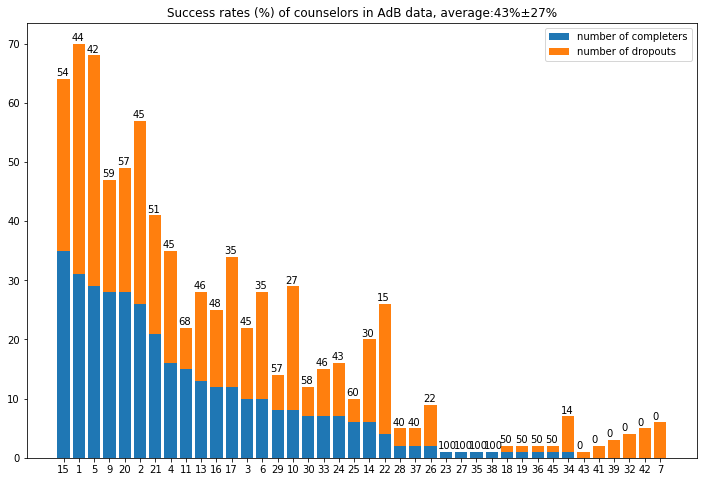

In [28]:
import matplotlib.pyplot as plt

plotData = sorted(plotData,key=lambda x: x[1]+((100-x[2])/100),reverse=True)
fig,ax = plt.subplots(figsize=(12,8))
plt.bar([x[0] for x in plotData],[x[1] for x in plotData],label="number of completers")
plt.bar([x[0] for x in plotData],[x[2] for x in plotData],bottom=[x[1] for x in plotData],label="number of dropouts")
for i in range(0,len(plotData)):
    ax.text(i-0.5,plotData[i][1]+plotData[i][2]+0.5,int(100*plotData[i][1]/(plotData[i][1]+plotData[i][2])))
plt.title("Success rates (%) of counselors in AdB data, average:43%±27%")
plt.legend()
dummy = plt.show()

In [29]:
import numpy as np

round(100*np.average([x[1]/(x[1]+x[2]) for x in plotData])),round(100*np.std([x[1]/(x[1]+x[2]) for x in plotData]))

(43.0, 27.0)

In [30]:
round(100*np.average([x[1]/(x[1]+x[2]) for x in plotData if x[1]+x[2] > 1])),round(100*np.std([x[1]/(x[1]+x[2]) for x in plotData if x[1]+x[2] > 1]))

(38.0, 19.0)

## Sanity check: male vs female words

In [ ]:
import numpy as np
import os
import pandas as pd
import re
import sys
import xml.etree.ElementTree as ET
sys.path.append('/home/erikt/projects/e-mental-health/data-processing')
import tactus2table

DIRECTORY = "/home/erikt/projects/e-mental-health/usb/tmp/20190917/"
FILENAMEPREFIX = "^AdB"
TITLE = "0-title"
FIELDNAMEINTAKE = "Intake"
FIELDNAMEID = "0-id"
FIELDNAMEGENDER = "geslacht"
GZEXTENSION = ".gz"
XMLEXTENSION = ".xml"
MALE = "man"
FEMALE = "vrouw"
INTAKE = "Intake"

def shortenFileName(fileName):
    return(re.sub(XMLEXTENSION,"",re.sub(GZEXTENSION,"",fileName)))

In [ ]:
genders = {}
for inFileName in os.listdir(DIRECTORY):
    if re.search(FILENAMEPREFIX,inFileName):
        root = tactus2table.readRootFromFile(DIRECTORY+"/"+inFileName)
        questionnaires = tactus2table.getQuestionnaires(root,inFileName)
        for questionnaire in questionnaires: 
            if questionnaire[TITLE] == INTAKE:
                for fieldName in questionnaire:
                    if re.search(FIELDNAMEGENDER,fieldName):
                        genders[shortenFileName(questionnaire[FIELDNAMEID])] = questionnaire[fieldName].lower()
                        break
                break

In [ ]:
genderKeys = list(np.unique(np.array([genders[key] for key in genders])))
genderMailTexts = {}
for key in genderKeys: genderMailTexts[key] = {}
for result in range(0,len(mailTexts)):
    for fileId in mailTexts[result].keys():
        genderMailTexts[genders[fileId]][fileId] = mailTexts[result][fileId]
[(key,len(genderMailTexts[key])) for key in genderKeys]  

In [ ]:
tscoreData1 = makeTscoreData(uniqueTextArray(genderMailTexts[MALE]))
tscoreData2 = makeTscoreData(uniqueTextArray(genderMailTexts[FEMALE]))
computeTscores(tscoreData1,tscoreData2)

## Get treatment years

In [ ]:
FIELDNAMEDATE = "date"

endYears = []
startYears = []
treatmentYearList = {}
for clientId in allMails:
    startYear = str(allMails[clientId][0][FIELDNAMEDATE])[0:4]
    endYear = str(allMails[clientId][-1][FIELDNAMEDATE])[0:4]
    startYears.append(int(startYear))
    endYears.append(int(endYear))
    treatmentYears = startYear+"-"+endYear
    if treatmentYears in treatmentYearList: treatmentYearList[treatmentYears] += 1
    else: treatmentYearList[treatmentYears] = 1

years = {}
startYearsTotals = {}
endYearsTotals = {}
for i in range(0,len(startYears)):
    if startYears[i] in startYearsTotals: startYearsTotals[startYears[i]] += 1
    else: startYearsTotals[startYears[i]] = 1
    if endYears[i] in endYearsTotals: endYearsTotals[endYears[i]] += 1
    else: endYearsTotals[endYears[i]] = 1
    for year in range(startYears[i],endYears[i]+1):
        if year in years: years[year] += 1
        else: years[year] = 1
for year in sorted(years.keys()):
    print(years[year],year,startYearsTotals[year],endYearsTotals[year])
    
sum(years.values()),sum(startYearsTotals.values()),sum(endYearsTotals.values())

## Count mails of dropouts and completers 

In [ ]:
import numpy as np
import math

CODECOMPLETER = "2"

def std(data,avg):
    total = 0
    for i in range(0,len(data)): total += (data[i]-avg)**2
    return(math.sqrt(total/len(data)))

nbrOfClientMailsDropouts = []
nbrOfClientMailsCompleters = []
for clientId in allMails:
    clientMailCounter = 0
    for i in range(0,len(allMails[clientId])):
        if allMails[clientId][i][FIELDNAMEFROM] == CLIENT: clientMailCounter += 1
    if dropout[clientId] == CODEDROPOUT: nbrOfClientMailsDropouts.append(clientMailCounter)
    if dropout[clientId] == CODECOMPLETER: nbrOfClientMailsCompleters.append(clientMailCounter)
        
print("dropouts: ","average:",round(np.mean(nbrOfClientMailsDropouts),1),"+-",round(np.std(nbrOfClientMailsDropouts),1),\
                   "  median:",round(np.median(nbrOfClientMailsDropouts),1),"+-",round(std(nbrOfClientMailsDropouts,np.median(nbrOfClientMailsDropouts)),1))
print("finishers:","average:",round(np.mean(nbrOfClientMailsCompleters),1),"+-",round(np.std(nbrOfClientMailsCompleters),1),\
                   "median:",round(np.median(nbrOfClientMailsCompleters),1),"+-",round(std(nbrOfClientMailsCompleters,np.median(nbrOfClientMailsCompleters)),1))

In [ ]:
for d in nbrOfClientMailsDropouts: print(d,end=" ")

In [ ]:
for f in nbrOfClientMailsFinishers: print(f,end=" ")

In [ ]:
len(nbrOfClientMailsDropouts)